В данной работе воспользуемся встроенным в библиотеку sklearn набором данных [iris](https://archive.ics.uci.edu/ml/datasets/Iris). CSV-файл взят [отсюда](https://www.kaggle.com/uciml/iris).

Использованные источники:
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
* https://scikit-learn.org/stable/modules/multiclass.html
* https://scikit-learn.org/stable/modules/svm.html
* https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification
* https://stats.stackexchange.com/questions/14876/interpreting-distance-from-hyperplane-in-svm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
pd.options.display.max_columns = None

In [3]:
data = pd.read_csv('iris.csv', index_col=0)
data.index.name = None
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
def build_clf(ovo_ovr_clf_class, estimator_params, X_train, y_train):
    clf = ovo_ovr_clf_class(SVC(**estimator_params))
    clf.fit(X_train, y_train)
    return clf

In [5]:
def build_plots(fpr, tpr, roc_auc, classes):
    for i, species in enumerate(classes):
        plt.figure()
        lw = 2
        plt.plot(fpr[i],
                 tpr[i],
                 color='darkorange',
                 lw=lw,
                 label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for class %s' % species)
        plt.legend(loc="lower right")
        plt.show()

Для многоклассовой классификации лучше использовать подход **One VS One**: в таком случае будут построены классификаторы для каждой пары классов, что может иметь положительный эффект в случае, если классы несбалансированы.

Кратко и понятно о том, что такое **One VS One**, **One vs All** (**One vs Rest**) можно посмотреть в [этом](https://www.youtube.com/watch?v=_s3z8dQX3pM) ролике.

## Подход с OvR

In [6]:
classes = data['Species'].unique()

In [7]:
y = label_binarize(data['Species'], classes=classes)
X = data.drop(columns=['Species']).copy()
n_classes = len(classes)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [9]:
clf = build_clf(OneVsRestClassifier,
                {"kernel": "linear",
                 "random_state": 42},
                X_train,
                y_train)

Функция [decision_function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) возвращает расстояния для каждого объекта от гиперплоскости класса. Соотвественно, чем больше расстояние - тем больше вероятность принадлежности объекта к определенному классу.

При использовании аргумента `probability=True` (если я все верно понял [отсюда](https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities)) метод `decision_function` вместо расстояний до разделяющей гиперплоскости будет возвращать вероятность принадлежности к тому или иному классу.

In [10]:
y_score = clf.decision_function(X_test)

In [11]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_score[:, i])

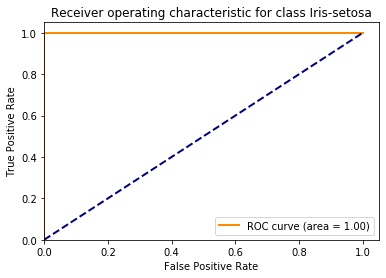

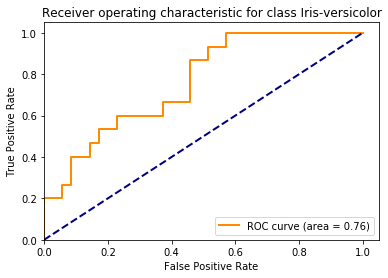

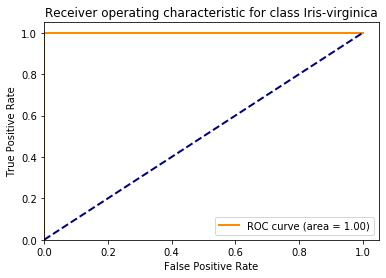

In [12]:
build_plots(fpr, tpr, roc_auc, classes)

## Подход с OvO

In [13]:
# Создаем словарь для преобразования видов
species_dict = dict([[species, index] for index, species in enumerate(data['Species'].unique())])
classes = list(species_dict.keys())

In [14]:
y = data['Species'].replace(species_dict)
X = data.drop(columns=['Species']).copy()
n_classes = len(species_dict)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [16]:
clf = build_clf(OneVsOneClassifier,
                {"kernel": "linear",
                 "random_state": 42},
                X_train,
                y_train)

In [17]:
y_score = clf.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_test_class = (y_test == i) * 1
    y_pred = y_score[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_test_class, y_pred)
    roc_auc[i] = roc_auc_score(y_test_class, y_pred)

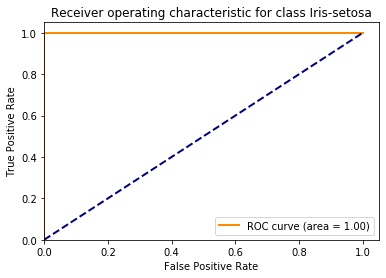

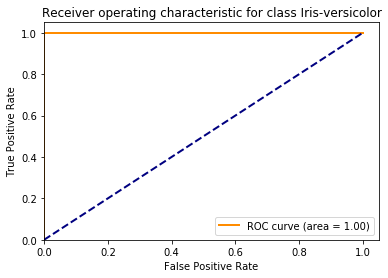

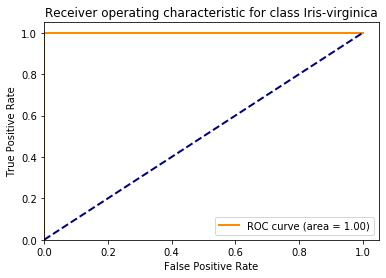

In [18]:
build_plots(fpr, tpr, roc_auc, classes)

PS: в задании указано построить [таблицу сопряженности](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D0%B0_%D1%81%D0%BE%D0%BF%D1%80%D1%8F%D0%B6%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8). Для каких переменных? Не уместнее ли здесь confusion matrix?